<a href="https://colab.research.google.com/github/cgarciaflor/Yolov5/blob/main/Smart_PKLot_Detection_using_YOLOv5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies



For this project we will be using the official YOLOv5 repository from ultralytics

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 31 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.02 MiB | 13.34 MiB/s, done.
Resolving deltas: 100% (11382/11382), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets


print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.4 MB/s eta 0:00:00
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


## Downloading the Dataset into the Notebook

The dataset we decided to use is the PKLot Dataset which is a robust parking lot dataset collected by the **Federal University of Parana (UFPR) and the Pontificial Catholic University of Parana (PUCPR), both located in Curitiba, Brazil.**

The dataset contains 12k+ images of parking lots from both universities

The dataset was found and downloaded from Roboflow and can be found [here](https://public.roboflow.com/object-detection/pklot)

This dataset is split between 70% training, 20% validation, and 10% testing

 -------------------------------------

Acknowledge:

Almeida, P., Oliveira, L. S., Silva Jr, E., Britto Jr, A., Koerich, A., PKLot – A robust dataset for parking lot classification, Expert Systems with Applications, 42(11):4937-4949, 2015.

In [3]:
%cd /content/
!curl -L "https://public.roboflow.com/ds/xugHO6CKJU?key=X9LMSkN6eO" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/2013-04-16_07_45_02_jpg.rf.e428ec70fb7e2a848817466c725bcb04.txt  
 extracting: train/labels/2013-04-16_07_55_02_jpg.rf.a6624571b2833dc996fce24b98eac1fc.txt  
 extracting: train/labels/2013-04-16_08_00_02_jpg.rf.b4b059ed577a72101d500dc8285d8d30.txt  
 extracting: train/labels/2013-04-16_08_05_02_jpg.rf.891be3b531b85840ee7af9d5cb4a467a.txt  
 extracting: train/labels/2013-04-16_08_10_02_jpg.rf.ed972f4caf46e296305c834938b09e7d.txt  
 extracting: train/labels/2013-04-16_08_15_02_jpg.rf.a45f2ababd324f6a461eab73fd61e5fc.txt  
 extracting: train/labels/2013-04-16_08_20_02_jpg.rf.35409a67291d756343c31cac3bc3e0e0.txt  
 extracting: train/labels/2013-04-16_08_25_02_jpg.rf.68ee10dba825ec434be0c3c1efcfdceb.txt  
 extracting: train/labels/2013-04-16_08_30_02_jpg.rf.d1ac2036f74f2acd0f57f1e89b41576a.txt  
 extracting: train/labels/2013-04-16_08_35_02_jpg.rf.5e7ed9679d1245b51788cdfee9dda708.txt  
 extracting: train/labels/201

# Small sample of some of the training images

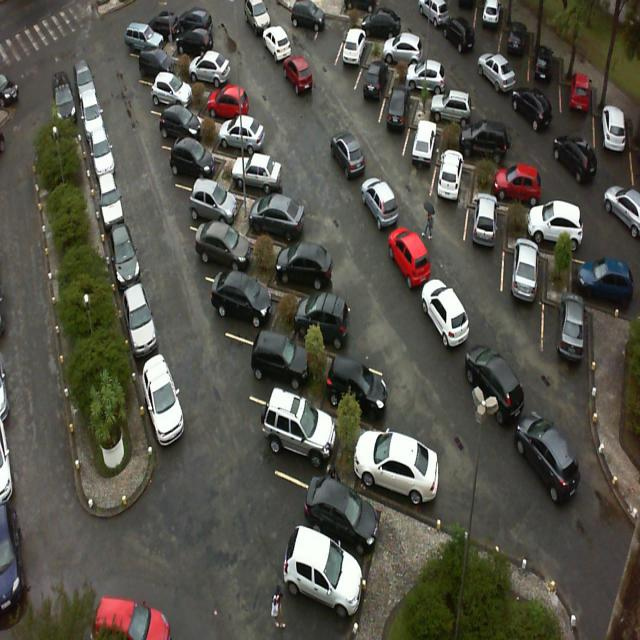

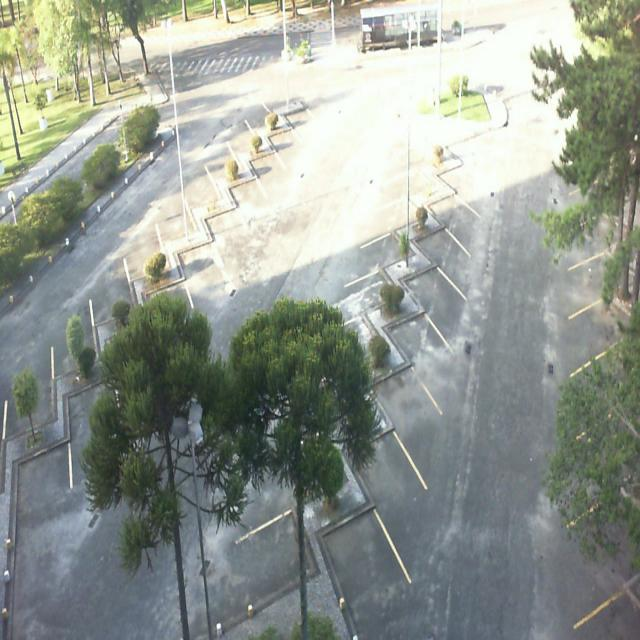

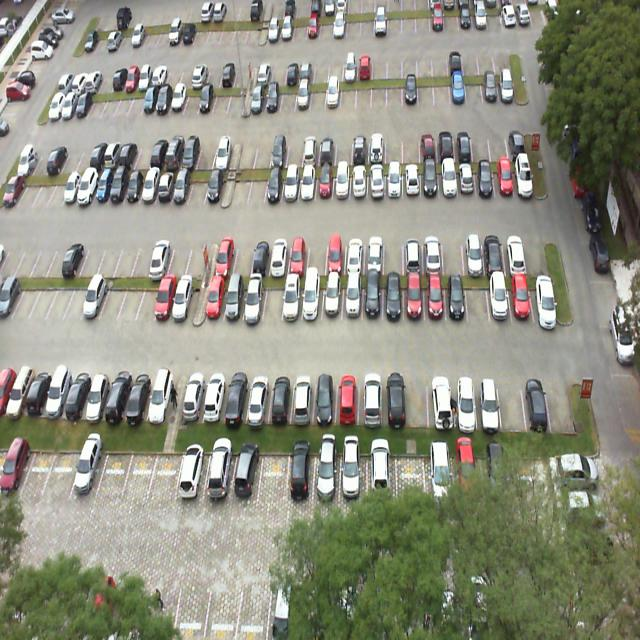

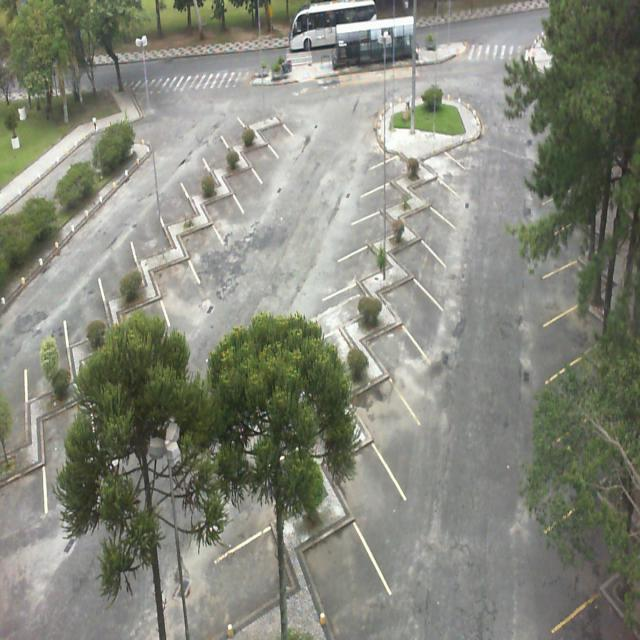

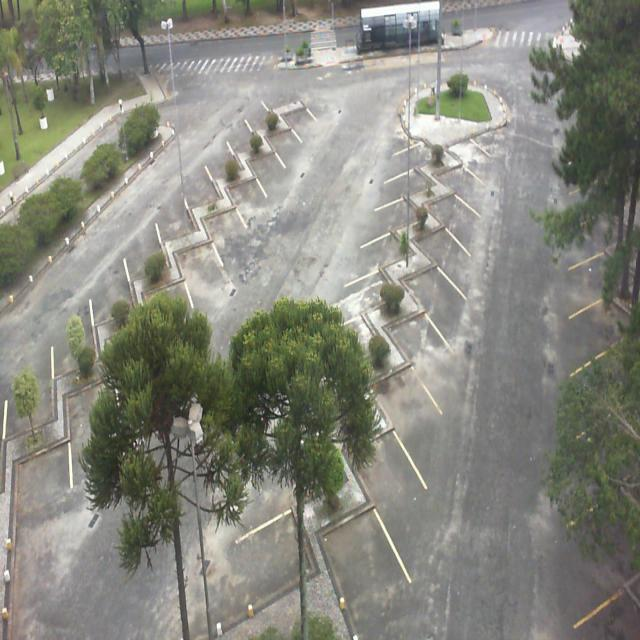

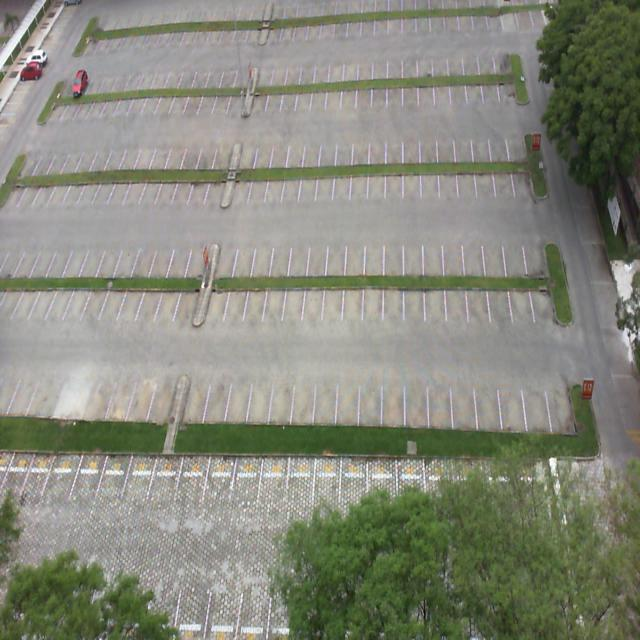

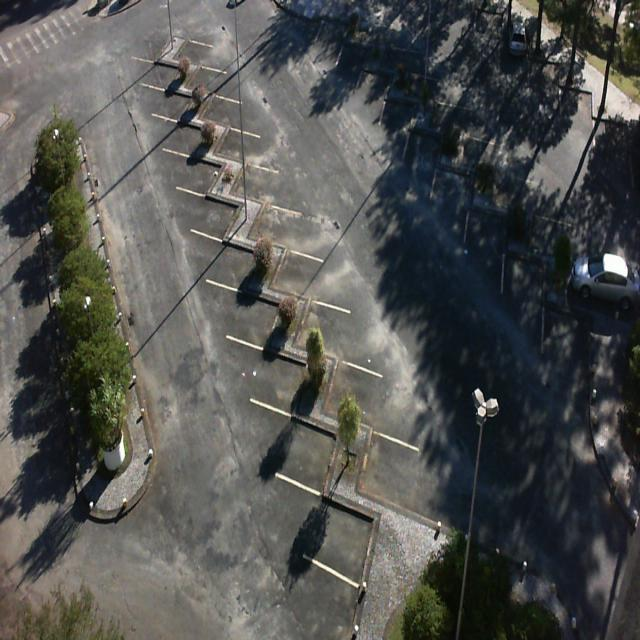

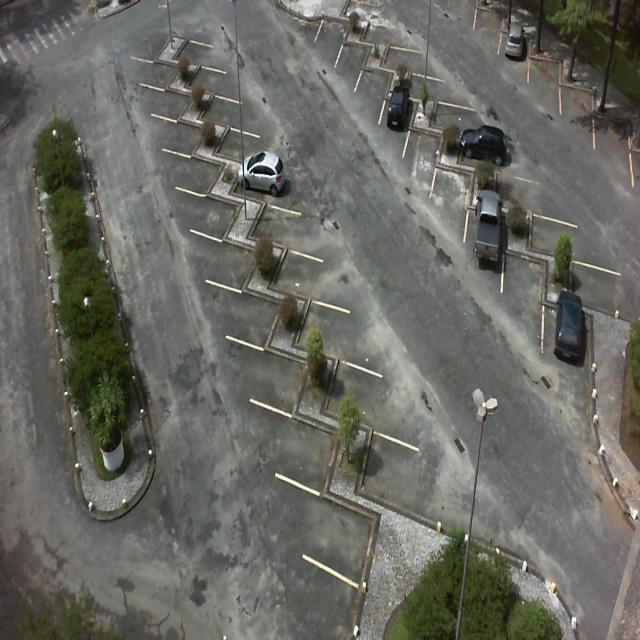

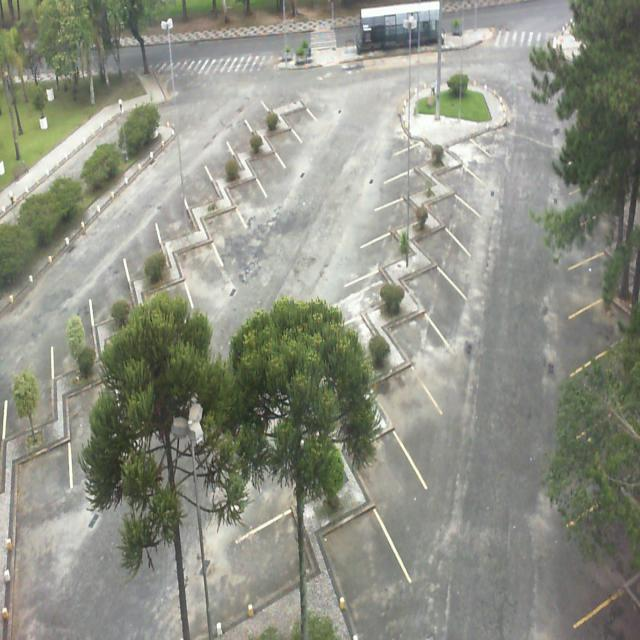

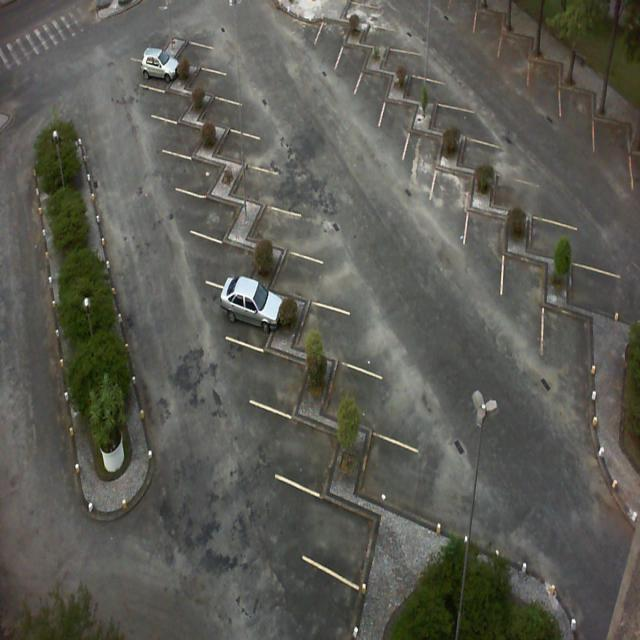

In [5]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/train/images/*.jpg')[:10]:
    display(Image(filename=imageName))

In [4]:
%cd /content/yolov5

/content/yolov5


# Display the number of classes and their names


In [ ]:
%cat /content/data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['space-empty', 'space-occupied']

# Updating Model Configuration and Architecture

Write a yaml script that defines the number of classes that our model will have to be trained on

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

This is the default build of the model

We will be changing the amount of classes to fit out problem, a 2 class problem

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

Since our problem and dataset consist of 2 classes (space-empty, space-occupied) we will need to edit the number of classes which the yolo model will learn since by default it is set to 80 classes

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

Along with that, hyperparameteres are also already defined, and for the purpose of this project, these parameters will be sufficient for training


In [4]:
%cat /content/hyp.yaml

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0


# Training the Custom YOLOv5 Detector

Here, we are able to pass a number of arguments:
- **img:** input image size
- **batch:**  batch size
- **epochs:**  number of training epochs
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights
- **name:** name of the folder that the results will be saved in
- **cache:** cache images for faster training

We can now train our custom model using our imported dataset.

Since our data set is fairly large we will train for 40 epochs.

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 40 --data /content/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-23 18:37:55.541318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 18:37:55.541372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 18:37:55.664152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 18:37:56.892174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, nop

# Evaluating The Performance Of Our Custom YOLOv5 Model

Results will be saved in the yolov5s_results folder since thats the name we passed within the train.py parameter above.

Training losses and performance metrics are also saved to Tensorboard and to the file we named in the parameter to train.py.

We can print the results here.

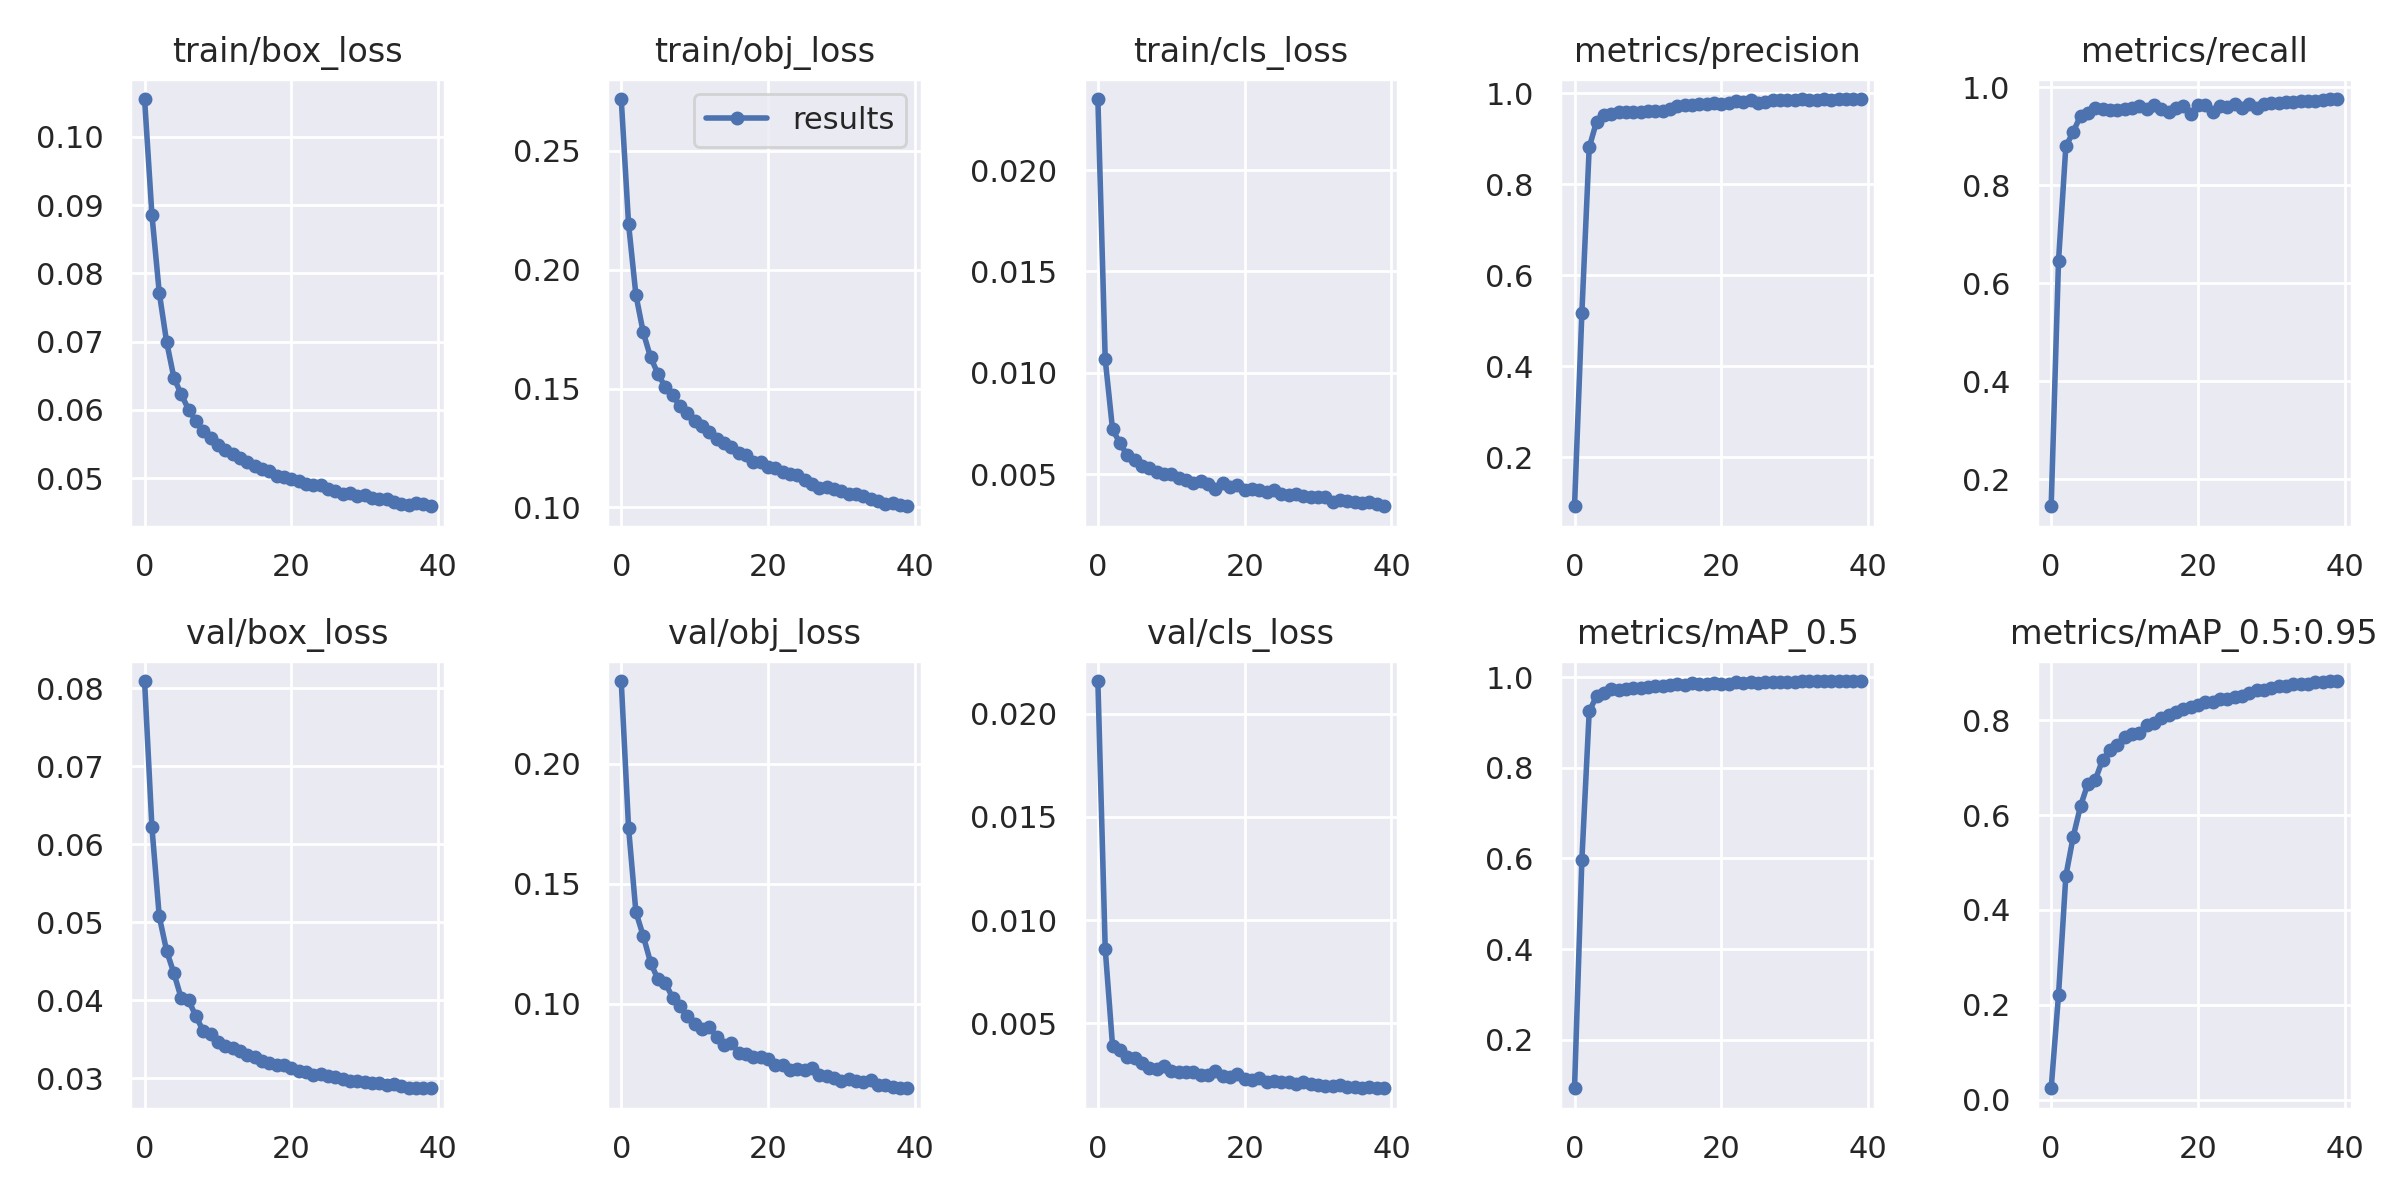

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)

This is an example of a batch used within the training that consist of images with there labels and any augmentations present


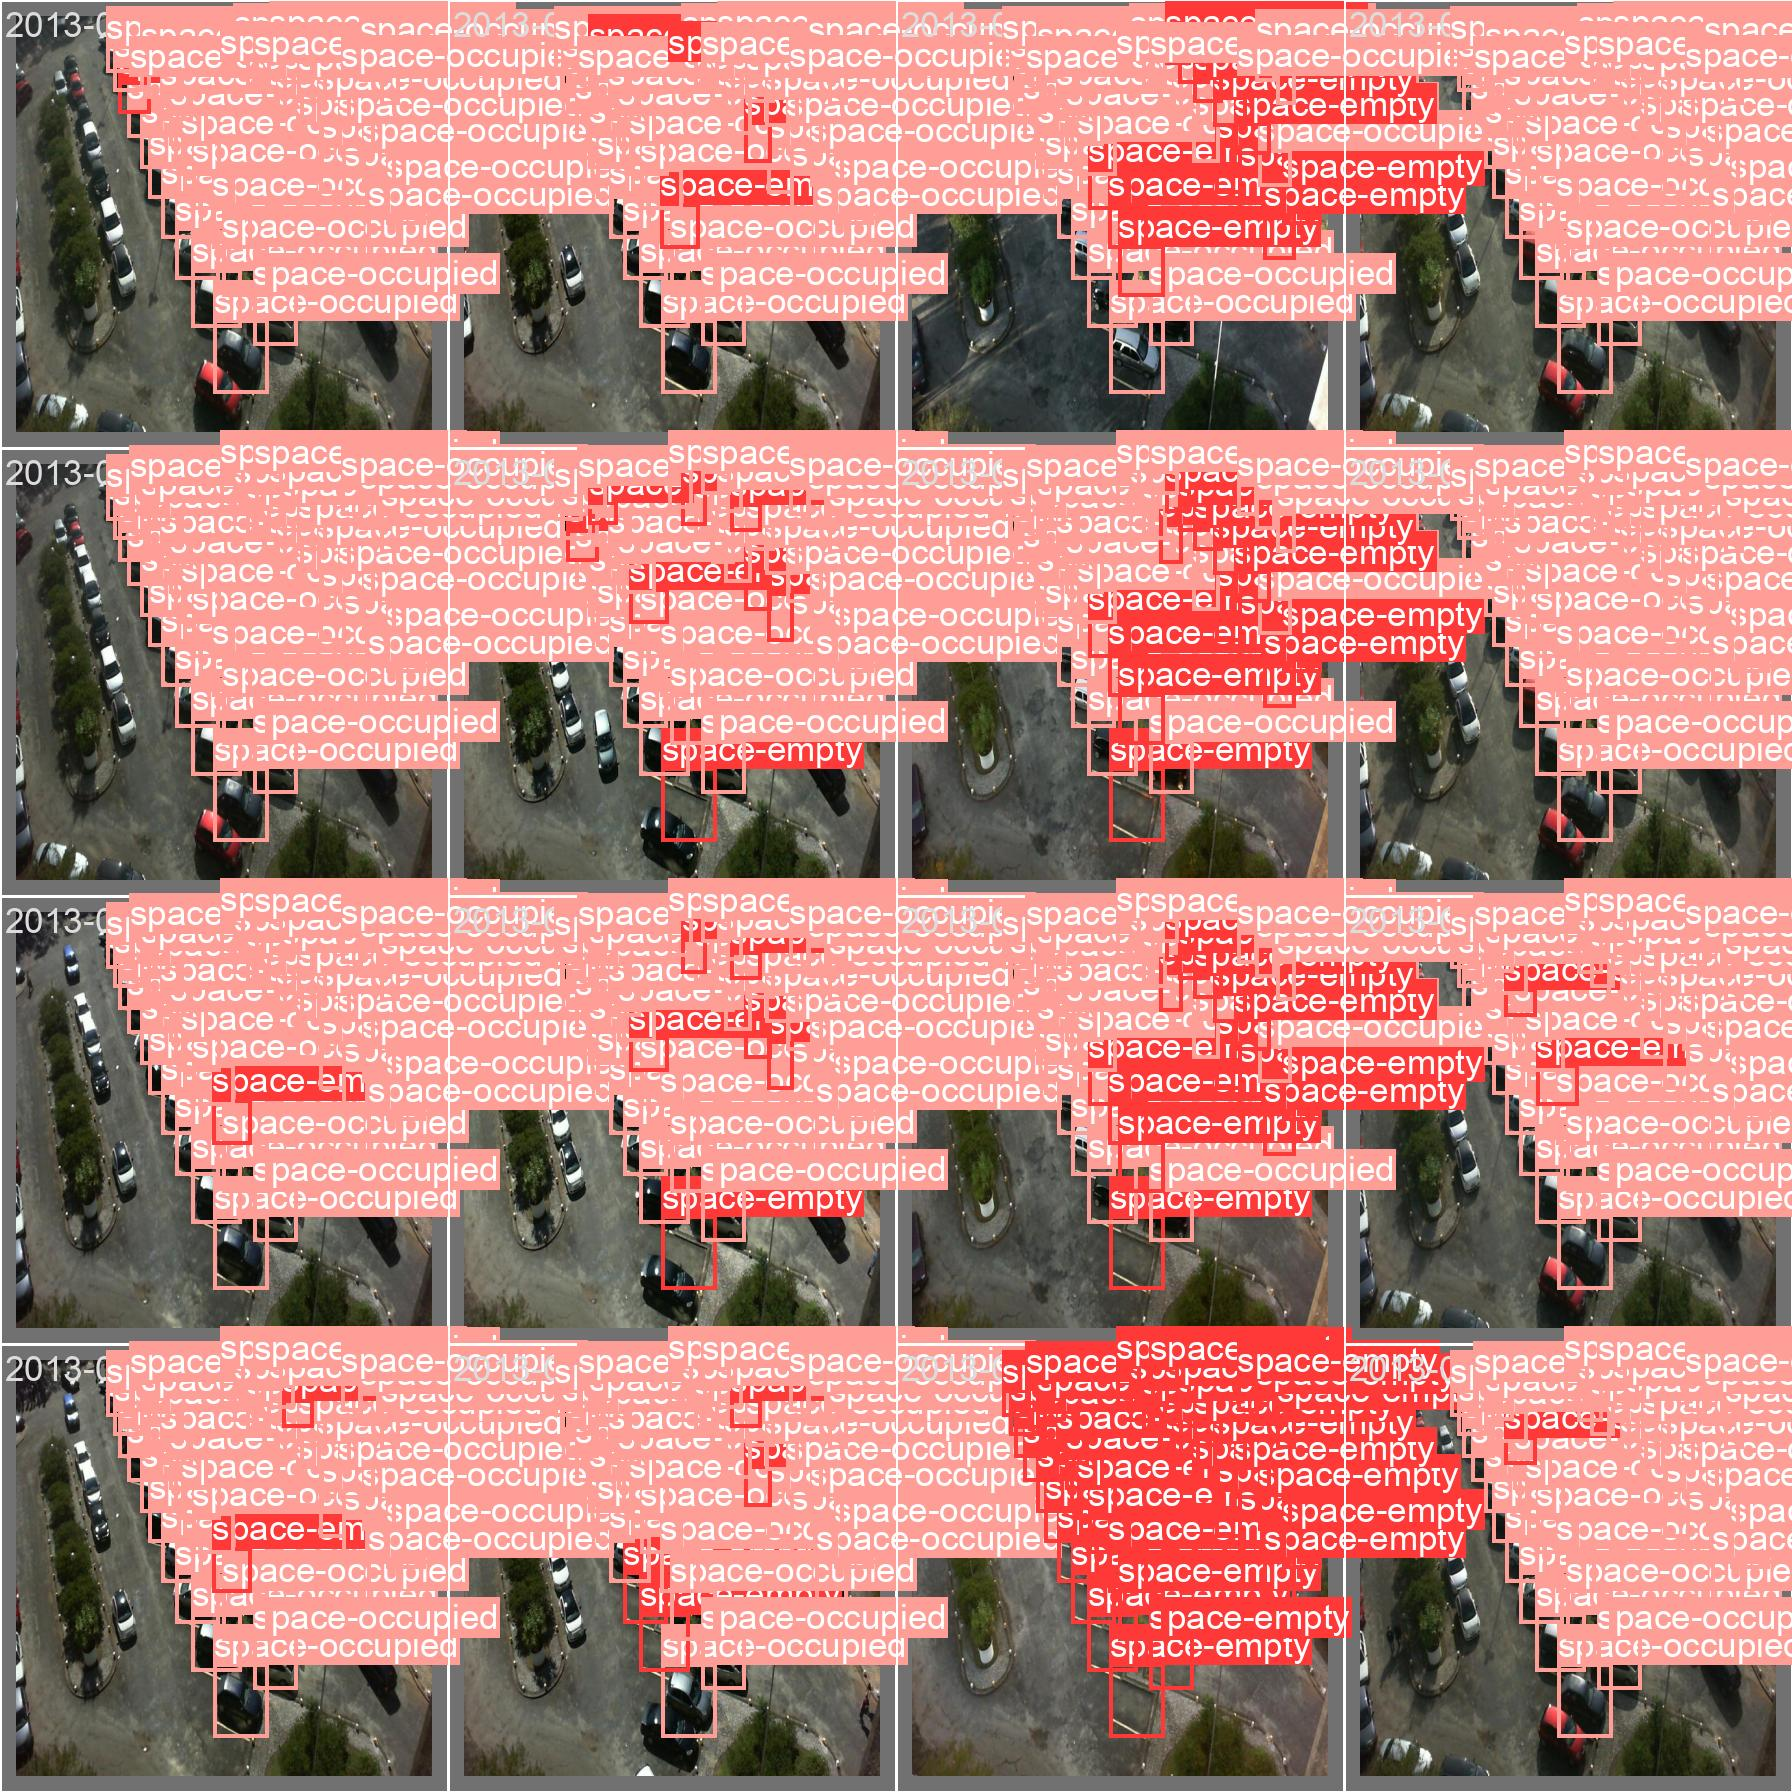

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


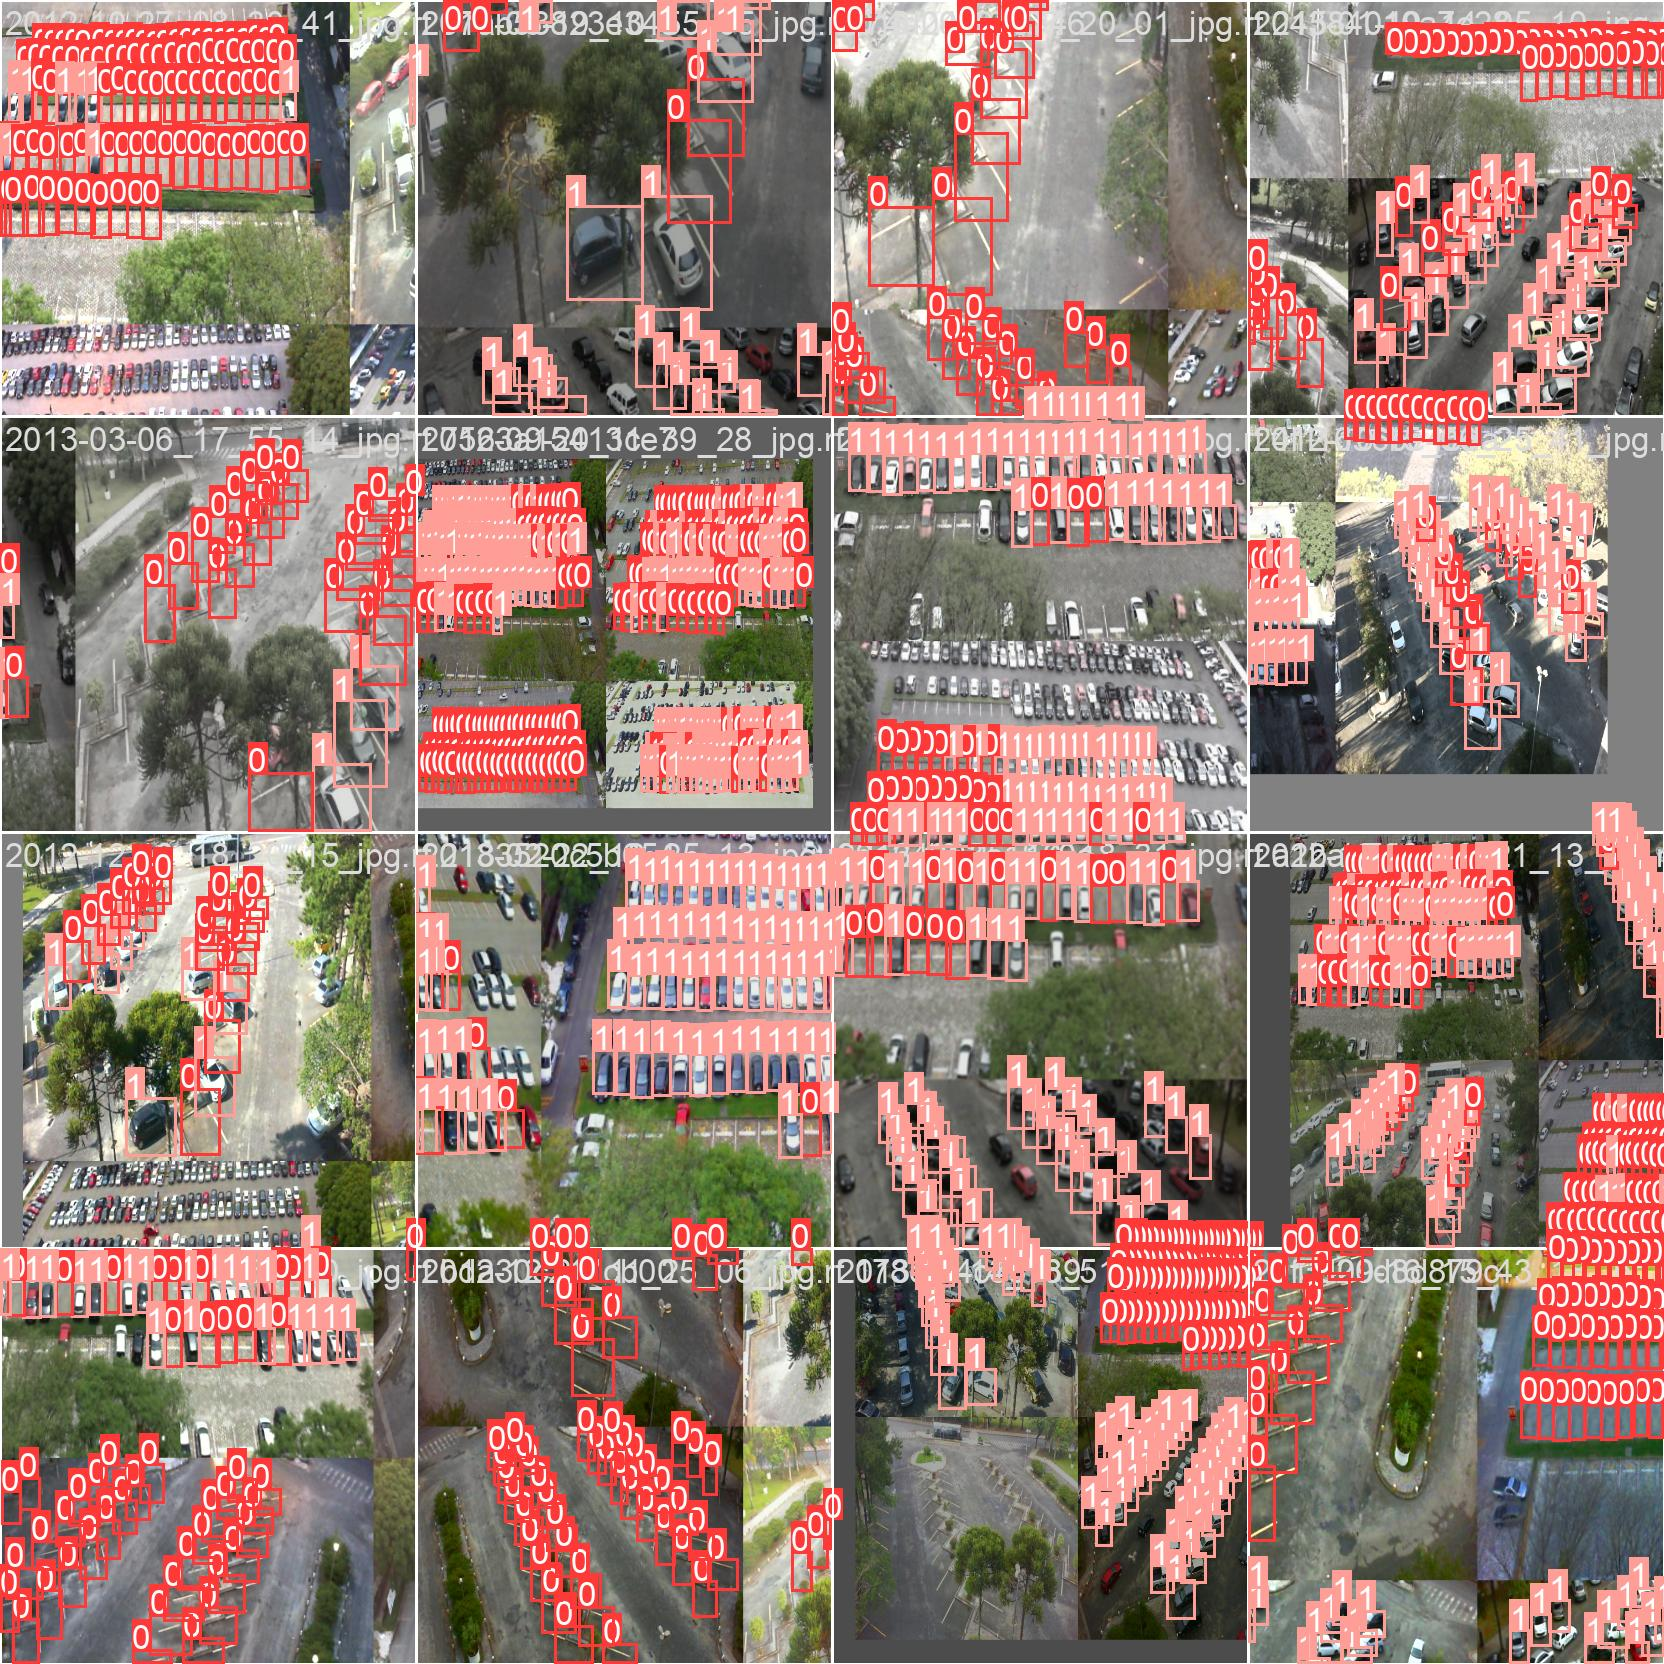

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference With Trained Weights

Next, we can run inference with a pretrained checkpoint on all images in the `test/images` folder to understand how our model performs on our test set.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


We can see that the weights saved are the last ones used and the ones that gave us the best results during training

In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


detect.py will now run inferences and predictions on our testing images within the testing folder using the best weights from training

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7249215 parameters, 0 gradients
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1242 /content/test/images/2012-09-11_15_53_00_jpg.rf.8282544a640a23df05bd245a9210e663.jpg: 416x416 28 space-emptys, 73 space-occupieds, 7.7ms
image 2/1242 /content/test/images/2012-09-11_16_48_36_jpg.rf.4ecc8c87c61680ccc73edc218a2c8d7d.jpg: 416x416 25 space-emptys, 76 sp

#  Visualize How The Model Did

The model will save the images in `runs/detect/exp#` folder and we can now pull a few of the test images using the script below to see how the model did.

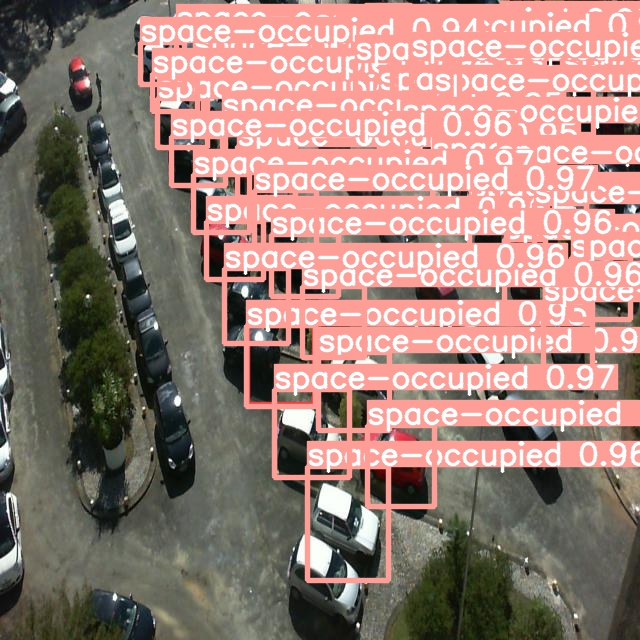

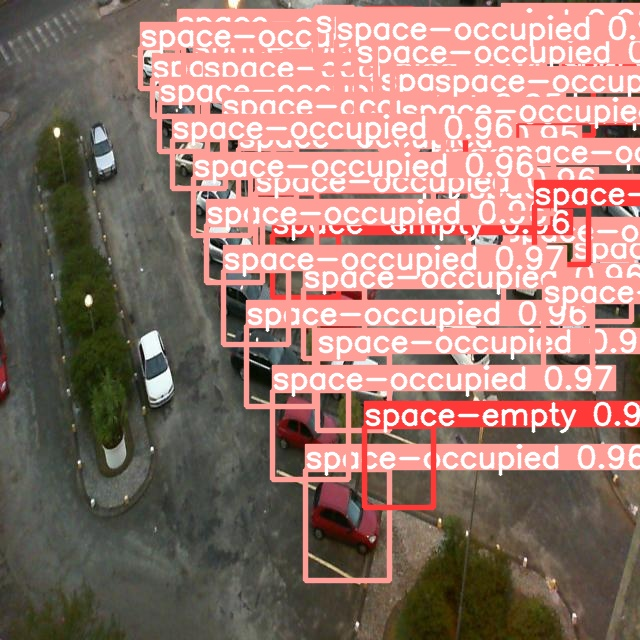

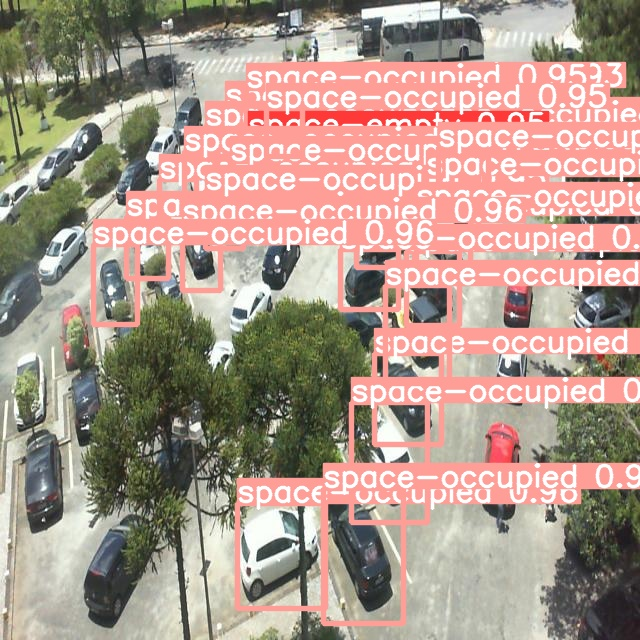

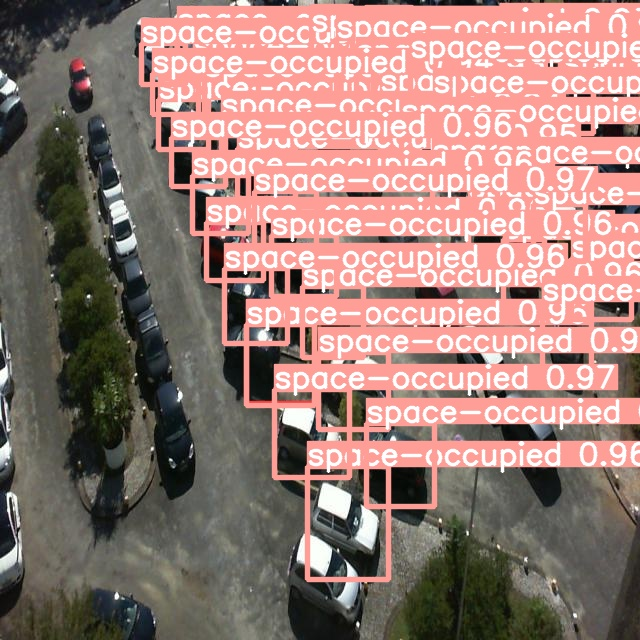

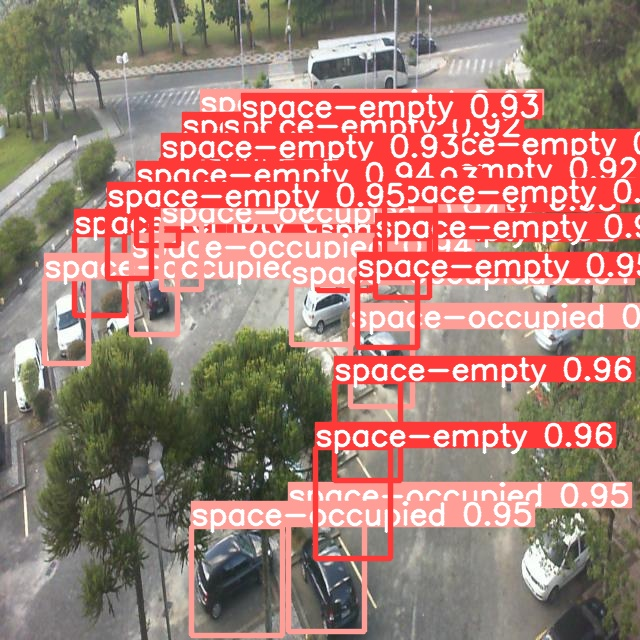

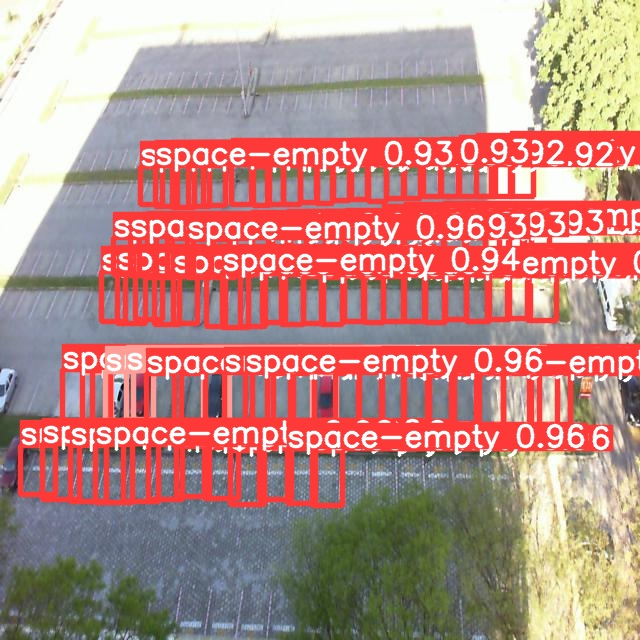

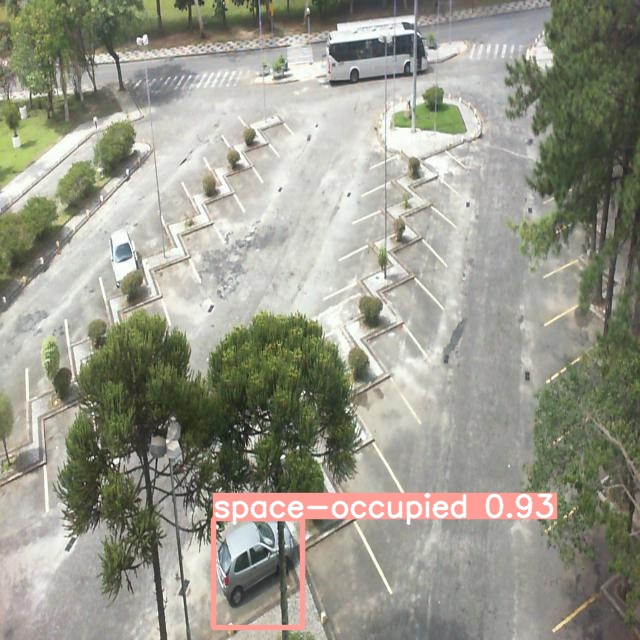

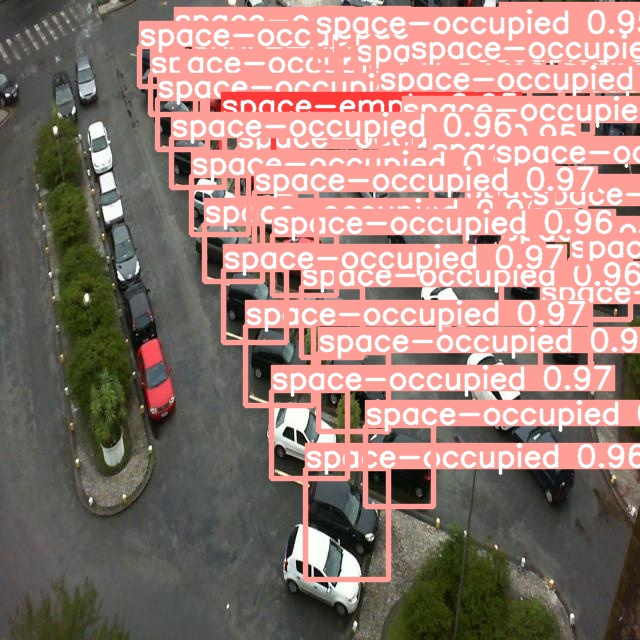

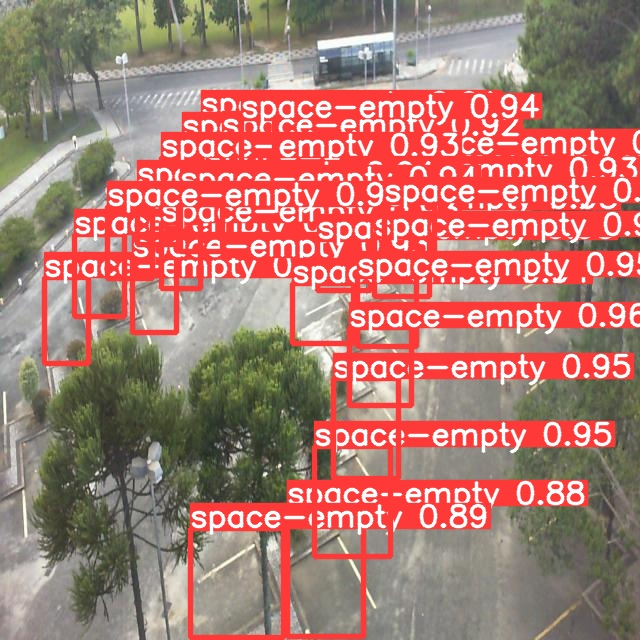

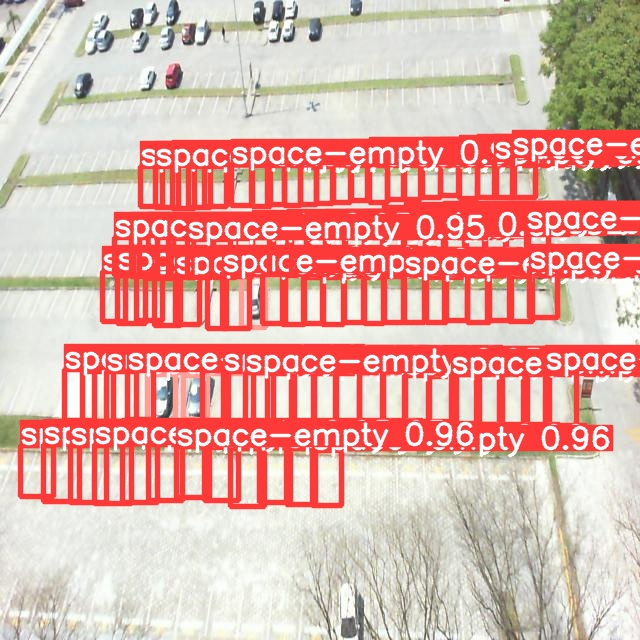

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))